In [1]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import *; from dateutil.relativedelta import *

In [2]:
conn = sqlite3.connect('/Users/elichouatt/Downloads/FPA_FOD_20170508.sqlite')
# df = pd.read_sql_query("SELECT * from Fires", conn)
# conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
# conn = sqlite3.connect('/Users/lahat/Downloads/FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT * from Fires", conn)

## Data Exploration

In [3]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [4]:
### Cause and code are injective (one-to-one)
df[['STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR']].drop_duplicates().sort_values(by='STAT_CAUSE_CODE')

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
22,1.0,Lightning
12,2.0,Equipment Use
6,3.0,Smoking
8,4.0,Campfire
5,5.0,Debris Burning
33,6.0,Railroad
4,7.0,Arson
45,8.0,Children
1,9.0,Miscellaneous
146,10.0,Fireworks


In [5]:
### Each team member got 1/3 of the columns to decide which to keep/drop and why
df.iloc[:, 26:].head()

,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,NaN,None,2.0,B,47.600845,-116.306789,14.0,MISSING/NOT SPECIFIED,ID,Kootenai,055,Kootenai,b'\x00\x01\xad\x10\x00\x00pqTn\xa2\x13]\xc0\x9...
1,234.0,1800,0.1,A,48.403300,-108.289600,8.0,PRIVATE,MT,None,None,None,b'\x00\x01\xad\x10\x00\x00\xf8:p\xce\x88\x12[\...
2,140.0,1630,1.5,B,40.668460,-99.089130,14.0,MISSING/NOT SPECIFIED,NE,None,None,None,b'\x00\x01\xad\x10\x00\x00\xe8\xc5PN\xb4\xc5X\...
3,NaN,None,2.0,B,39.000000,-78.269200,14.0,MISSING/NOT SPECIFIED,VA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\x05\xa3\x92:\x91S\...
4,NaN,None,5.0,B,30.993300,-89.863900,14.0,MISSING/NOT SPECIFIED,LA,None,None,None,b'\x00\x01\xad\x10\x00\x00\xe8\xc09#JwV\xc0\xf...


In [6]:
## these are the same, and if one is none the rest are also none
df['COUNTY'] = df['COUNTY'].str.lower().str.strip()
df['FIPS_NAME'] = df['FIPS_NAME'].str.lower().str.strip()
# df['FIPS_CODE'] = df['FIPS_CODE'].str.lower().str.strip()
count_fips = df[['COUNTY','FIPS_NAME', 'FIPS_CODE']].dropna()
count_fips[(count_fips['COUNTY']!=count_fips['FIPS_NAME'])&
           (count_fips['COUNTY']!=count_fips['FIPS_CODE'])&
           (count_fips['FIPS_CODE']!=count_fips['FIPS_NAME'])].head(10)

,COUNTY,FIPS_NAME,FIPS_CODE
9,31,cook,031
22,17,navajo,017
25,orangeburg county,orangeburg,075
32,19,douglas,019
35,st lawrence,st. lawrence,089
53,jf,jefferson,073
56,5,coconino,005
66,47,okanogan,047
71,69,waupaca,135
72,stevens county,stevens,065


In [7]:
df_fires = df.drop(columns=['OBJECTID','FOD_ID', 'FPA_ID', 'SOURCE_REPORTING_UNIT_NAME', 
                      'LOCAL_FIRE_REPORT_ID','LOCAL_INCIDENT_ID','FIRE_CODE', 
                      'FIRE_NAME','ICS_209_INCIDENT_NUMBER','ICS_209_NAME', 
                      'MTBS_ID', 'MTBS_FIRE_NAME', 'OWNER_DESCR',
                      'FIPS_CODE', 'FIPS_NAME', 'Shape'
                     ])
len(df_fires.columns)

23

In [8]:
## basic string cleaning
# df_fires = df_fires.fillna(value=np.nan)
# df_fires = df_fires.replace(to_replace='', value=np.nan)

In [9]:
## state exploration
df_fires['STATE'] = df_fires['STATE'].str.upper()
lst_states = list(df_fires['STATE'].unique())
len(lst_states)

52

In [10]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'PR']
len(states)

52

In [11]:
## PR state is not existing (ask shifter if its real). If it is, we will remove the rows with PR
for state in lst_states:
    if state not in states:
        print(state)

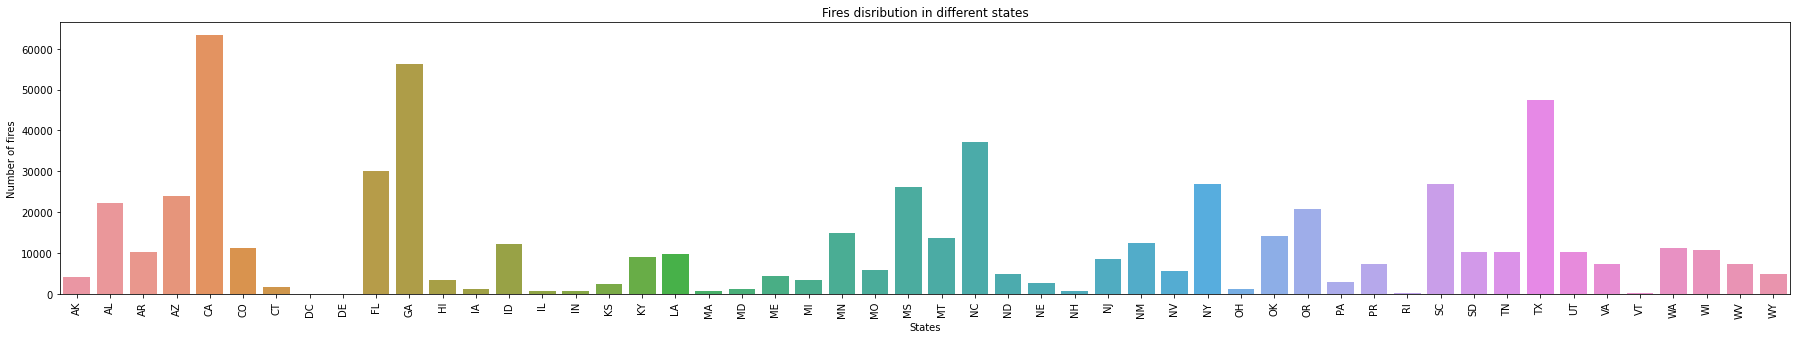

In [12]:
plt.figure(figsize=(31,5))
sns.countplot(data=df_fires, x=df_fires['STATE'], order=np.sort(df_fires['STATE'].unique()))
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Number of fires")
plt.title("Fires disribution in different states")
plt.show()

In [13]:
df_fires["COUNTY"].isnull().sum()

226115

We can constat that there are 226115 NaN values among more than 600K. We will replace each Nan value by the state  corresponding to its latitude/longitude coordinate

To not have conflicts we put all current county names in lower cases

In [14]:
df_fires["COUNTY"] = df_fires["COUNTY"].str.lower()
df_fires.loc[df_fires['COUNTY'].isnull(), 'COUNTY'] = df_fires.loc[df_fires['COUNTY'].isnull(),'STATE']

In [15]:
## overseeing staff exploration
SST = "SOURCE_SYSTEM_TYPE"
NRA = "NWCG_REPORTING_AGENCY"
df_fires[SST].nunique()  # categorial feature - NON FED, FED, INT AGNCY

3

In [16]:
df_fires[NRA].nunique()

11

In [17]:
NRA_VALUES = np.unique(df_fires[NRA])
NRA_VALUES

array(['BIA', 'BLM', 'BOR', 'DOD', 'DOE', 'FS', 'FWS', 'IA', 'NPS',
       'ST/C&L', 'TRIBE'], dtype=object)

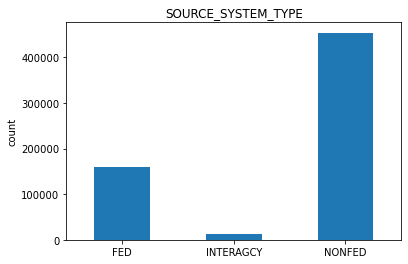

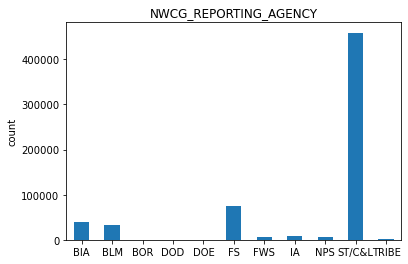

In [18]:
## the majority of NWCG REPORTING AGENCY is a State.
for col in [SST, NRA]:
    df_fires[col].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count', title=col)
    plt.show()

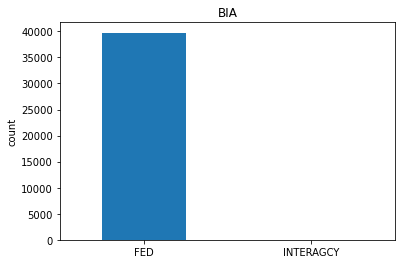

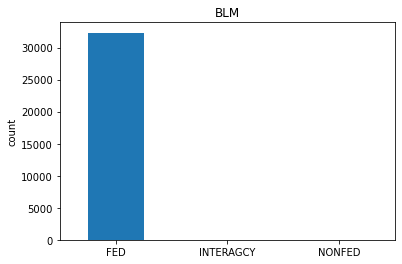

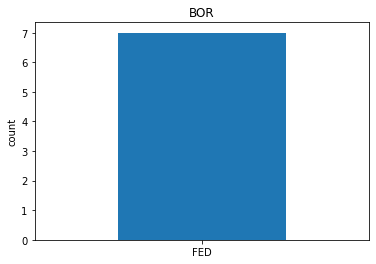

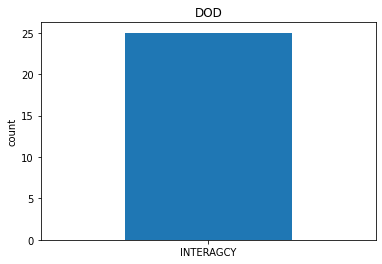

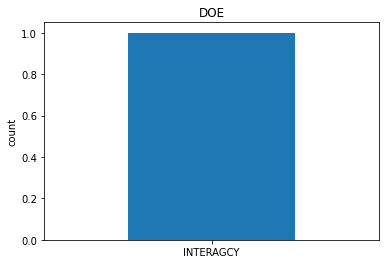

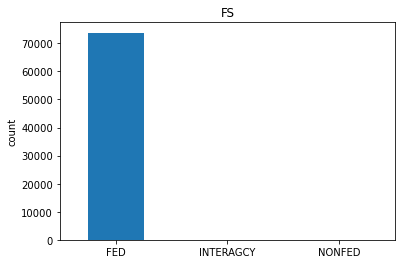

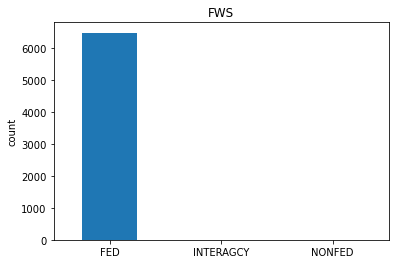

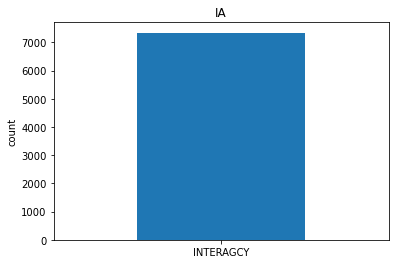

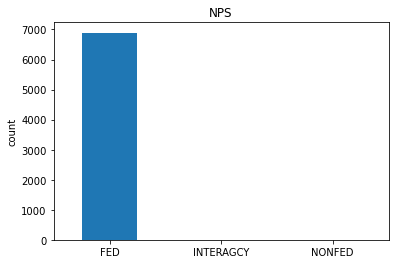

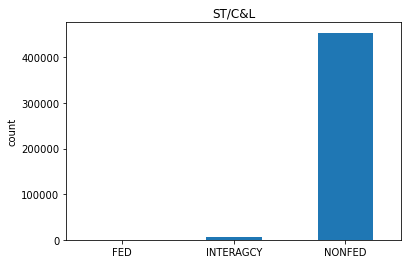

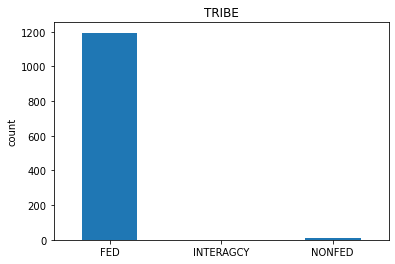

In [19]:
## the most SOURCE SYSTEM TYPE of ST/C&L (State unit reporting the fire report) is NONFED, maybe see the connection with nonfed to cause fire and see if it is the same in this case
for val in NRA_VALUES:
    df_fires[df_fires[NRA] == val][SST].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count', title=val)
    plt.show()

## Data Cleaning

In [20]:
df_fires.isna().sum(axis = 0)  # check wich columns still have null values. maybe will not be good to be in model

SOURCE_SYSTEM_TYPE               0
SOURCE_SYSTEM                    0
NWCG_REPORTING_AGENCY            0
NWCG_REPORTING_UNIT_ID           0
NWCG_REPORTING_UNIT_NAME         0
SOURCE_REPORTING_UNIT            0
COMPLEX_NAME                625075
FIRE_YEAR                        0
DISCOVERY_DATE                   0
DISCOVERY_DOY                    0
DISCOVERY_TIME              294076
STAT_CAUSE_CODE                  0
STAT_CAUSE_DESCR                 0
CONT_DATE                   297088
CONT_DOY                    297088
CONT_TIME                   323724
FIRE_SIZE                        0
FIRE_SIZE_CLASS                  0
LATITUDE                         0
LONGITUDE                        0
OWNER_CODE                       0
STATE                            0
COUNTY                           0
dtype: int64

In [21]:
df_fires.shape

(626822, 23)

### Time Features engineering

In [22]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()

In [23]:
seconds_per_min = 60 
min_per_hour = 60
# Arrange the dates for the Model Data Frame.
df_fires["DISCOVERY_DATE"] = pd.to_datetime(df_fires['DISCOVERY_DATE'] - epoch, unit='D')
df_fires["FULL_DISCOVERY_DATE"] = pd.to_datetime(df_fires['DISCOVERY_DATE'], format = "%Y%j",errors="ignore")
df_fires["FULL_DISCOVERY_DATE"] = df_fires.FULL_DISCOVERY_DATE.astype(str) + " " + df_fires.DISCOVERY_TIME.str[:2] + ":" + df_fires.DISCOVERY_TIME.str[2:]
df_fires["FULL_DISCOVERY_DATE"] = pd.to_datetime(df_fires["FULL_DISCOVERY_DATE"])
df_fires["CONT_DATE"] = pd.to_datetime(df_fires['CONT_DATE'] - epoch, unit='D')
df_fires["FULL_CONT_DATE"] = pd.to_datetime(df_fires["CONT_DATE"], format = "%Y%j",errors="ignore")
df_fires["FULL_CONT_DATE"] = df_fires.FULL_CONT_DATE.astype(str) + " " + df_fires.CONT_TIME.str[:2] + ":" + df_fires.CONT_TIME.str[2:]
df_fires["FULL_CONT_DATE"] = pd.to_datetime(df_fires["FULL_CONT_DATE"], errors='coerce')
# Calculate the durations of the fire from substraction of discovery and control time.
df_fires["DELTA_TIME"] = None
df_fires["DELTA_TIME_HOUR"] = None
df_fires.loc[df_fires['FULL_CONT_DATE'].notna(), 'DELTA_TIME'] = (df_fires["FULL_CONT_DATE"] - df_fires["FULL_DISCOVERY_DATE"])
df_fires.loc[df_fires['FULL_CONT_DATE'].notna(), 'DELTA_TIME_HOUR'] = (df_fires["FULL_CONT_DATE"] - df_fires["FULL_DISCOVERY_DATE"]).dt.days*24 + ((df_fires["FULL_CONT_DATE"] - df_fires["FULL_DISCOVERY_DATE"]).dt.seconds/seconds_per_min)/min_per_hour
# Extract week day and the month for each fire.
df_fires["DAY_OF_WEEK"] = df_fires.DISCOVERY_DATE.dt.weekday
df_fires["MONTH"] = df_fires.DISCOVERY_DATE.dt.month
# float hour feature
df_fires['DISCOVERY_TIME_FRM'] = df_fires['DISCOVERY_TIME'].apply(lambda row : datetime.strptime(str(row), "%H%M").hour + datetime.strptime(str(row), "%H%M").minute/min_per_hour  if row else np.nan)
df_fires['CONT_TIME_FRM'] = df_fires['CONT_TIME'].apply(lambda row : datetime.strptime(str(row), "%H%M").hour + datetime.strptime(str(row), "%H%M").minute/min_per_hour  if row else np.nan)
df_fires.head()

,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,STATE,COUNTY,FULL_DISCOVERY_DATE,FULL_CONT_DATE,DELTA_TIME,DELTA_TIME_HOUR,DAY_OF_WEEK,MONTH,DISCOVERY_TIME_FRM,CONT_TIME_FRM
0,NONFED,ST-NASF,ST/C&L,USIDIDS,Idaho Department of Lands,ID310,None,1998,1998-09-17,260,...,ID,kootenai,NaT,NaT,None,None,3,9,NaN,NaN
1,FED,DOI-WFMI,BIA,USMTFBA,Fort Belknap Agency,MTFBA,None,2011,2011-08-22,234,...,MT,MT,2011-08-22 16:45:00,2011-08-22 18:00:00,0 days 01:15:00,1.25,0,8,16.750000,18.0
2,NONFED,ST-NASF,ST/C&L,USNENES,Nebraska Department of Forestry,NENFS,None,2012,2012-05-19,140,...,NE,NE,2012-05-19 15:47:00,2012-05-19 16:30:00,0 days 00:43:00,0.716667,5,5,15.783333,16.5
3,NONFED,ST-VAVAS,ST/C&L,USVAVAS,Virginia Department of Forestry,VAVAS3,None,2002,2002-01-04,4,...,VA,VA,NaT,NaT,None,None,4,1,NaN,NaN
4,NONFED,ST-LALAS,ST/C&L,USLALAS,Louisiana Office of Forestry,LALAS1,None,2002,2002-05-16,136,...,LA,LA,NaT,NaT,None,None,3,5,NaN,NaN


In [24]:
np.max(df_fires['DELTA_TIME_HOUR'])

87673.0

In [25]:
# drop outiliners
df_fires.drop(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] > 10000) & (df_fires['FIRE_SIZE'] < 5)].index, inplace=True)

In [26]:
df_fires[["DELTA_TIME", "DELTA_TIME_HOUR"]]

,DELTA_TIME,DELTA_TIME_HOUR
0,None,None
1,0 days 01:15:00,1.25
2,0 days 00:43:00,0.716667
3,None,None
4,None,None
...,...,...
626817,0 days 00:00:00,0.0
626818,0 days 00:00:00,0.0
626819,0 days 00:00:00,0.0
626820,None,None


In [27]:
average_duration = df_fires['DELTA_TIME_HOUR'].mean()
average_duration

29.526126613407378

In [28]:
df_fires[['DISCOVERY_DATE', 'CONT_DATE', 'DELTA_TIME']]

,DISCOVERY_DATE,CONT_DATE,DELTA_TIME
0,1998-09-17,NaT,None
1,2011-08-22,2011-08-22,0 days 01:15:00
2,2012-05-19,2012-05-19,0 days 00:43:00
3,2002-01-04,NaT,None
4,2002-05-16,NaT,None
...,...,...,...
626817,2005-05-29,2005-05-29,0 days 00:00:00
626818,2000-07-12,2000-07-12,0 days 00:00:00
626819,2001-05-03,2001-05-03,0 days 00:00:00
626820,2007-07-13,NaT,None


In [29]:
# df_fires = df_fires.drop(df_fires[df_fires['DELTA_TIME_HOUR']==0].index).reset_index(drop=True)

(array([246562.,  24897.,   4696.,   5038.,   2689.,   1217.,   1685.,
           841.,    767.,    848.]),
 array([0.0, 14.996666666666666, 29.993333333333332, 44.989999999999995,
        59.986666666666665, 74.98333333333333, 89.97999999999999,
        104.97666666666666, 119.97333333333333, 134.97, 149.96666666666667],
       dtype=object),
 <BarContainer object of 10 artists>)

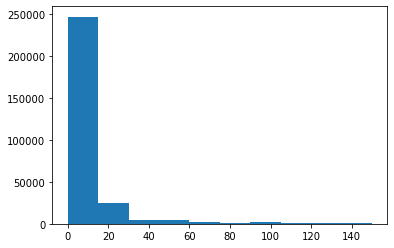

In [30]:
plt.hist(df_fires.loc[df_fires['DELTA_TIME_HOUR'] < 150]['DELTA_TIME_HOUR'], bins=10)

transform columns (cyclic transformation on the hours, days (is it useful), months (for seasons))
complete null values

## Geographic Features engineering

We want to fill the missing Delta Time values with the median of the Delta Time per Fire Class.

In [31]:
## classes A and B are too similar
df_fires.groupby('FIRE_SIZE_CLASS')['DELTA_TIME_HOUR'].describe()

,count,unique,top,freq
FIRE_SIZE_CLASS,,,,
A,127109.0,6965.0,0.0,15383.0
B,129026.0,6113.0,0.0,19120.0
C,30723.0,3869.0,0.0,2849.0
D,4968.0,2149.0,0.0,253.0
E,2893.0,1807.0,0.0,93.0
F,1908.0,1524.0,0.0,15.0
G,1035.0,991.0,12.0,4.0


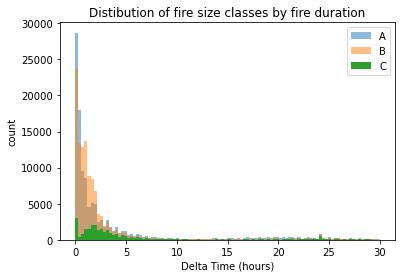

In [32]:
plt.hist(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] < 30) & (df_fires['FIRE_SIZE_CLASS']=='A')]['DELTA_TIME_HOUR'], bins=100, label='A', alpha=0.5)
plt.hist(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] < 30) & (df_fires['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B', alpha=0.5)
plt.hist(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] < 30) & (df_fires['FIRE_SIZE_CLASS']=='C')]['DELTA_TIME_HOUR'], bins=100, label='C')
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.title("Distibution of fire size classes by fire duration")
plt.legend()

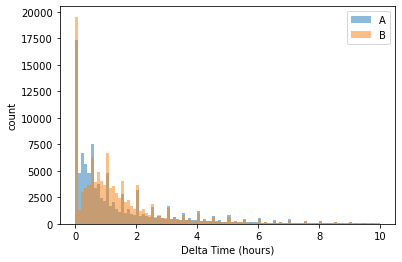

In [33]:
plt.hist(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] < 10) & (df_fires['FIRE_SIZE_CLASS']=='A')]['DELTA_TIME_HOUR'], bins=100, label='A', alpha=0.5)
plt.hist(df_fires.loc[(df_fires['DELTA_TIME_HOUR'] < 10) & (df_fires['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B', alpha=0.5)
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.legend()

In [34]:
## maybe we should combine them
df2 = df_fires.copy()
df2['FIRE_SIZE_CLASS']=df2['FIRE_SIZE_CLASS'].replace('A','B')
df2.groupby('FIRE_SIZE_CLASS')['DELTA_TIME_HOUR'].describe()

,count,unique,top,freq
FIRE_SIZE_CLASS,,,,
B,256135.0,9565.0,0.0,34503.0
C,30723.0,3869.0,0.0,2849.0
D,4968.0,2149.0,0.0,253.0
E,2893.0,1807.0,0.0,93.0
F,1908.0,1524.0,0.0,15.0
G,1035.0,991.0,12.0,4.0


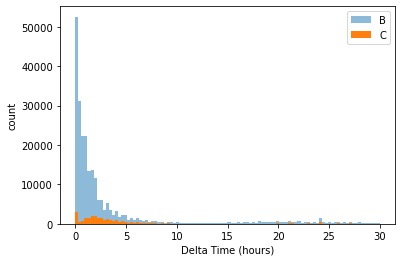

In [35]:
plt.hist(df2.loc[(df2['DELTA_TIME_HOUR'] < 30) & (df2['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B', alpha=0.5)
plt.hist(df2.loc[(df2['DELTA_TIME_HOUR'] < 30) & (df2['FIRE_SIZE_CLASS']=='C')]['DELTA_TIME_HOUR'], bins=100, label='C')
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.legend()

In [36]:
## or define a new upper bound for class A
df3 = df_fires.copy()
df3['FIRE_SIZE_CLASS'] = df3['FIRE_SIZE_CLASS'].mask(df3['FIRE_SIZE'] <= 1, 'A')
df3.groupby('FIRE_SIZE_CLASS')['DELTA_TIME_HOUR'].describe()

,count,unique,top,freq
FIRE_SIZE_CLASS,,,,
A,191519.0,8311.0,0.0,24411.0
B,64616.0,4254.0,0.0,10092.0
C,30723.0,3869.0,0.0,2849.0
D,4968.0,2149.0,0.0,253.0
E,2893.0,1807.0,0.0,93.0
F,1908.0,1524.0,0.0,15.0
G,1035.0,991.0,12.0,4.0


In [37]:
## redfine A upper boundary to still keep it as the smallest fire catagory but make it more differentiated than B
## use median duration for null time values
df3 = df_fires.copy()
df3['FIRE_SIZE_CLASS'] = df3['FIRE_SIZE_CLASS'].mask(df3['FIRE_SIZE'] <= 1, 'A')
df3['FIRE_SIZE_CLASS'] = df3['FIRE_SIZE_CLASS'].mask((1 < df3['FIRE_SIZE']) & (df3['FIRE_SIZE'] <= 9.9), 'B')
df3.groupby('FIRE_SIZE_CLASS')['DELTA_TIME_HOUR'].describe()

,count,unique,top,freq
FIRE_SIZE_CLASS,,,,
A,191519.0,8311.0,0.0,24411.0
B,64616.0,4254.0,0.0,10092.0
C,30723.0,3869.0,0.0,2849.0
D,4968.0,2149.0,0.0,253.0
E,2893.0,1807.0,0.0,93.0
F,1908.0,1524.0,0.0,15.0
G,1035.0,991.0,12.0,4.0


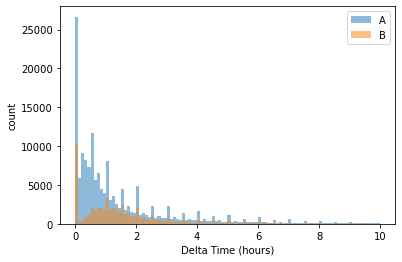

In [38]:
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='A')]['DELTA_TIME_HOUR'], bins=100, label='A', alpha=0.5)
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B', alpha=0.5)
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.legend()

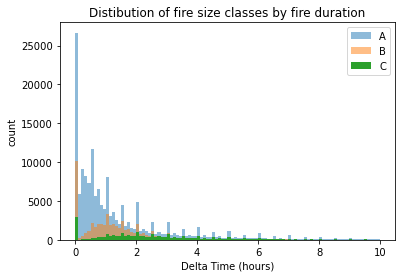

In [39]:
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='A')]['DELTA_TIME_HOUR'], bins=100, label='A', alpha=0.5)
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B', alpha=0.5)
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='C')]['DELTA_TIME_HOUR'], bins=100, label='C')
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.title("Distibution of fire size classes by fire duration")

plt.legend()

In [40]:
df3 = df_fires.copy()
df3['FIRE_SIZE_CLASS'] = df3['FIRE_SIZE_CLASS'].mask(df3['FIRE_SIZE'] <= 3, 'A')
df3.groupby('FIRE_SIZE_CLASS')['DELTA_TIME_HOUR'].describe()

,count,unique,top,freq
FIRE_SIZE_CLASS,,,,
A,230101.0,8984.0,0.0,31518.0
B,26034.0,2736.0,0.0,2985.0
C,30723.0,3869.0,0.0,2849.0
D,4968.0,2149.0,0.0,253.0
E,2893.0,1807.0,0.0,93.0
F,1908.0,1524.0,0.0,15.0
G,1035.0,991.0,12.0,4.0


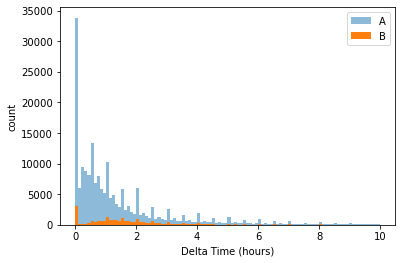

In [41]:
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='A')]['DELTA_TIME_HOUR'], bins=100, label='A', alpha=0.5)
plt.hist(df3.loc[(df3['DELTA_TIME_HOUR'] < 10) & (df3['FIRE_SIZE_CLASS']=='B')]['DELTA_TIME_HOUR'], bins=100, label='B')
plt.xlabel("Delta Time (hours)")
plt.ylabel("count")
plt.legend()

In [42]:
## fill time duration with median of new classes
df_fires['FIRE_SIZE_CLASS'] = df_fires['FIRE_SIZE_CLASS'].mask(df_fires['FIRE_SIZE'] <= 1, 'A')
df_fires['DELTA_TIME_HOUR'] = df_fires[['FIRE_SIZE_CLASS', 'DELTA_TIME_HOUR']].groupby('FIRE_SIZE_CLASS').transform(lambda x: x.fillna(x.median()))
df_fires['DELTA_TIME_HOUR'].isna().sum()

0

In [43]:
states_to_regions = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

In [44]:
lst=[]
for state in states_to_regions:
    if state not in states:
        lst.append(state)
for state in lst:
    del states_to_regions[state]
print(len(states_to_regions))

52


In [45]:
fire_prone_state = {
        'AK': 1,
        'AL': 2,
        'AR': 2,
        'AZ': 5,
        'CA': 5,
        'CO': 3,
        'CT': 1,
        'DC': 1,
        'DE': 2,
        'FL': 5,
        'GA': 2,
        'HI': 1,
        'IA': 2,
        'ID': 5,
        'IL': 1,
        'IN': 1,
        'KS': 3,
        'KY': 3,
        'LA': 2,
        'MA': 2,
        'MD': 2,
        'ME': 1,
        'MI': 2,
        'MN': 3,
        'MO': 2,
        'MS': 2,
        'MT': 3,
        'NC': 2,
        'ND': 3,
        'NE': 3,
        'NH': 1,
        'NJ': 3,
        'NM': 5,
        'NV': 5,
        'NY': 1,
        'OH': 1,
        'OK': 4,
        'OR': 4,
        'PA': 1,
        'PR': 1,
        'RI': 1,
        'SC': 2,
        'SD': 4,
        'TN': 1,
        'TX': 4,
        'UT': 4,
        'VA': 3,
        'VT': 1,
        'WA': 4,
        'WI': 2,
        'WV': 3,
        'WY': 4
}

In [46]:
## encode all string features
df_fires["REGION"] = df_fires["STATE"].replace(states, list(states_to_regions.values()))
df_fires["FREQUENCIES"] = df_fires.groupby("STATE")["STATE"].transform('size')
df_fires["FIRE_PRONE"] = df_fires["STATE"].replace(states, list(fire_prone_state.values()))

fire_size_class_encode = {
    'A':0,
    'B':1,
    'C':2,
    'D':3,
    'E':4,
    'F':5,
    'G':6
}

## encode as number of entries in a region - is the region more prone to fires
region_encoding = dict(df_fires.groupby(['REGION']).size())

df_fires.replace({"REGION":region_encoding, "FIRE_SIZE_CLASS":fire_size_class_encode}, inplace=True)

In [47]:
df_fires[['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 
                'REGION', 'FREQUENCIES','FIRE_PRONE']].head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,REGION,FREQUENCIES,FIRE_PRONE
0,2.0,1,47.600845,-116.306789,194779,12180,5
1,0.1,0,48.403300,-108.289600,194779,13613,3
2,1.5,1,40.668460,-99.089130,194779,2704,3
3,2.0,1,39.000000,-78.269200,194779,7296,4
4,5.0,1,30.993300,-89.863900,288542,9808,2


In [48]:
df_fires.isna().sum()

SOURCE_SYSTEM_TYPE               0
SOURCE_SYSTEM                    0
NWCG_REPORTING_AGENCY            0
NWCG_REPORTING_UNIT_ID           0
NWCG_REPORTING_UNIT_NAME         0
SOURCE_REPORTING_UNIT            0
COMPLEX_NAME                625068
FIRE_YEAR                        0
DISCOVERY_DATE                   0
DISCOVERY_DOY                    0
DISCOVERY_TIME              294076
STAT_CAUSE_CODE                  0
STAT_CAUSE_DESCR                 0
CONT_DATE                   297088
CONT_DOY                    297088
CONT_TIME                   323724
FIRE_SIZE                        0
FIRE_SIZE_CLASS                  0
LATITUDE                         0
LONGITUDE                        0
OWNER_CODE                       0
STATE                            0
COUNTY                           0
FULL_DISCOVERY_DATE         294076
FULL_CONT_DATE              323860
DELTA_TIME                  329153
DELTA_TIME_HOUR                  0
DAY_OF_WEEK                      0
MONTH               

## Time Feature engineering continued - filling missing values

In [49]:
df_fires = df_fires.drop(columns=['SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY',
       'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
       'SOURCE_REPORTING_UNIT', 'COMPLEX_NAME', 'OWNER_CODE', 'STAT_CAUSE_DESCR', 'COUNTY'])
df_fires.head(10)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,...,FULL_CONT_DATE,DELTA_TIME,DELTA_TIME_HOUR,DAY_OF_WEEK,MONTH,DISCOVERY_TIME_FRM,CONT_TIME_FRM,REGION,FREQUENCIES,FIRE_PRONE
0,1998,1998-09-17,260,None,13.0,NaT,NaN,None,2.0,1,...,NaT,None,1.416667,3,9,NaN,NaN,194779,12180,5
1,2011,2011-08-22,234,1645,9.0,2011-08-22,234.0,1800,0.1,0,...,2011-08-22 18:00:00,0 days 01:15:00,1.250000,0,8,16.750000,18.000000,194779,13613,3
2,2012,2012-05-19,140,1547,9.0,2012-05-19,140.0,1630,1.5,1,...,2012-05-19 16:30:00,0 days 00:43:00,0.716667,5,5,15.783333,16.500000,194779,2704,3
3,2002,2002-01-04,4,None,9.0,NaT,NaN,None,2.0,1,...,NaT,None,1.416667,4,1,NaN,NaN,194779,7296,4
4,2002,2002-05-16,136,None,7.0,NaT,NaN,None,5.0,1,...,NaT,None,1.416667,3,5,NaN,NaN,288542,9808,2
5,2008,2008-04-18,109,2045,5.0,2008-04-18,109.0,2045,3.0,1,...,2008-04-18 20:45:00,0 days 00:00:00,0.000000,4,4,20.750000,20.750000,288542,9006,3
6,1999,1999-11-20,324,1643,3.0,NaT,NaN,None,10.0,2,...,NaT,None,3.000000,5,11,16.716667,NaN,50283,5981,2
7,2001,2001-05-03,123,1740,7.0,NaT,NaN,None,10.0,2,...,NaT,None,3.000000,3,5,17.666667,NaN,288542,26235,2
8,1996,1996-10-19,293,None,4.0,NaT,NaN,None,70.0,2,...,NaT,None,3.000000,5,10,NaN,NaN,50283,14980,3
9,2005,2005-07-29,210,1600,4.0,2005-07-30,211.0,1725,0.1,0,...,2005-07-30 17:25:00,1 days 01:25:00,25.416667,4,7,16.000000,17.416667,50283,14980,3


In [50]:
### in this year, for fires of this size class in areas with this fire prone level, the avg discovery time is

disc_time_per_year_region_class_prone = df_fires.groupby(['FIRE_YEAR', 'REGION', 'FIRE_SIZE_CLASS', 'FIRE_PRONE', 'FREQUENCIES'])['DISCOVERY_TIME_FRM'].mean().reset_index()
disc_time_per_year_region_class_prone.head(5)

,FIRE_YEAR,REGION,FIRE_SIZE_CLASS,FIRE_PRONE,FREQUENCIES,DISCOVERY_TIME_FRM
0,1992,7724,0,1,3323,12.461667
1,1992,7724,0,1,4226,15.461765
2,1992,7724,1,1,3323,0.000000
3,1992,7724,1,1,4226,17.839286
4,1992,7724,2,1,3323,NaN


In [51]:
# some entries are unique to year, region, class, prone
disc_time_per_year_region_class_prone[disc_time_per_year_region_class_prone['DISCOVERY_TIME_FRM'].isna()]

,FIRE_YEAR,REGION,FIRE_SIZE_CLASS,FIRE_PRONE,FREQUENCIES,DISCOVERY_TIME_FRM
4,1992,7724,2,1,3323,NaN
6,1992,7724,3,1,3323,NaN
49,1992,50283,4,3,14980,NaN
51,1992,50283,5,3,14980,NaN
53,1992,85487,0,1,804,NaN
...,...,...,...,...,...,...
5743,2015,288542,0,3,150,NaN
5757,2015,288542,1,3,150,NaN
5771,2015,288542,2,3,150,NaN
5781,2015,288542,3,2,22352,NaN


In [52]:
## then each year+fire size class+fire prone has a median and we can fill the missing values

df_fires = df_fires.merge(disc_time_per_year_region_class_prone, on=['FIRE_YEAR', 'REGION', 'FIRE_SIZE_CLASS', 'FIRE_PRONE', 'FREQUENCIES'])
df_fires['DISCOVERY_TIME_FRM_x'] = df_fires['DISCOVERY_TIME_FRM_x'].fillna(df_fires['DISCOVERY_TIME_FRM_y'])
df_fires['DISCOVERY_TIME_FRM_x'].isna().sum()

12498

In [53]:
df_fires.drop(columns=['DISCOVERY_TIME_FRM_y'], inplace=True)
df_fires.rename(columns={'DISCOVERY_TIME_FRM_x': 'DISCOVERY_TIME_FRM'}, inplace=True)
df_fires['DISCOVERY_TIME_FRM'].isna().sum()

12498

In [54]:
# these are the rows we are going to drop
# for the rest of the rows we will fill the containted time missing values using reverse engineering
df_fires = df_fires.dropna(subset=['DISCOVERY_TIME_FRM'])
df_fires.isna().sum()

FIRE_YEAR                   0
DISCOVERY_DATE              0
DISCOVERY_DOY               0
DISCOVERY_TIME         281578
STAT_CAUSE_CODE             0
CONT_DATE              285500
CONT_DOY               285500
CONT_TIME              311246
FIRE_SIZE                   0
FIRE_SIZE_CLASS             0
LATITUDE                    0
LONGITUDE                   0
STATE                       0
FULL_DISCOVERY_DATE    281578
FULL_CONT_DATE         311381
DELTA_TIME             316655
DELTA_TIME_HOUR             0
DAY_OF_WEEK                 0
MONTH                       0
DISCOVERY_TIME_FRM          0
CONT_TIME_FRM          311381
REGION                      0
FREQUENCIES                 0
FIRE_PRONE                  0
dtype: int64

In [55]:
# reverse engineering for cont time frm
df_fires['CONT_TIME_FRM'] = df_fires['CONT_TIME_FRM'].fillna((df_fires['DISCOVERY_TIME_FRM'] + df_fires['DELTA_TIME_HOUR'])%24)

In [56]:
### reverse engineering for cont time
hours = df_fires['CONT_TIME_FRM'].astype(int)
minutes = ((df_fires['CONT_TIME_FRM'] - hours)*60).astype(int)
time_int = hours * 100 + minutes
df_fires['CONT_TIME'] = df_fires['CONT_TIME'].fillna(time_int)

In [57]:
### reverse engineering for discovery time
hours = df_fires['DISCOVERY_TIME_FRM'].astype(int)
minutes = ((df_fires['DISCOVERY_TIME_FRM'] - hours)*60).astype(int)
time_int = hours * 100 + minutes
df_fires['DISCOVERY_TIME'] = df_fires['DISCOVERY_TIME'].fillna(time_int)

In [58]:
### reverse engineering for discovery date
import datetime

hours = df_fires['DISCOVERY_TIME'].apply(lambda x: str(x)[:2] if len(str(x))==4 else str(x)[:1]).astype(int)
minutes = df_fires['DISCOVERY_TIME'].apply(lambda x: str(x)[-2:]).astype(int)

create_datetime = lambda year, doy, hour, minute: datetime.datetime(year, 1, 1, hour, minute) + datetime.timedelta(doy - 1)
start_dates = pd.Series(map(create_datetime, df_fires['FIRE_YEAR'], df_fires['DISCOVERY_DOY'], hours, minutes))
df_fires['DISCOVERY_DATE'] = df_fires['DISCOVERY_DATE'].fillna(start_dates)

In [59]:
### reverse engineering for containted date
start_datetime = df_fires['DISCOVERY_DATE']

# function to convert a delta time in hours to a datetime.timedelta object
def hours_to_timedelta(hours):
    days, hours_float = divmod(hours, 24)
    hours, minutes_float = divmod(hours_float * 60, 60)
    minutes = round(minutes_float)
    return datetime.timedelta(days=days, hours=hours, minutes=minutes)

# apply the function to the delta_times Series to create a new Series of timedelta objects
timedelta_series = df_fires['DELTA_TIME_HOUR'].apply(hours_to_timedelta)

# create a new Series of end datetime objects by adding the timedelta to the start datetime
end_datetime_series = start_datetime + timedelta_series
df_fires['CONT_DATE'] = df_fires['CONT_DATE'].fillna(end_datetime_series)

In [60]:
### reverse engineering for cont doy
cont_doy = df_fires['CONT_DATE'].apply(lambda dt: dt if pd.isna(dt) else dt.timetuple().tm_yday)
df_fires['CONT_DOY'] = df_fires['CONT_DOY'].fillna(cont_doy)
df_fires.isna().sum()

FIRE_YEAR                   0
DISCOVERY_DATE              0
DISCOVERY_DOY               0
DISCOVERY_TIME              0
STAT_CAUSE_CODE             0
CONT_DATE                   0
CONT_DOY                    0
CONT_TIME                   0
FIRE_SIZE                   0
FIRE_SIZE_CLASS             0
LATITUDE                    0
LONGITUDE                   0
STATE                       0
FULL_DISCOVERY_DATE    281578
FULL_CONT_DATE         311381
DELTA_TIME             316655
DELTA_TIME_HOUR             0
DAY_OF_WEEK                 0
MONTH                       0
DISCOVERY_TIME_FRM          0
CONT_TIME_FRM               0
REGION                      0
FREQUENCIES                 0
FIRE_PRONE                  0
dtype: int64

## Weather conditions data

In [61]:
df_stormevents = pd.read_csv('/Users/elichouatt/Downloads/weather.csv', low_memory=False)

In [62]:
df_stormevents.head()

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,...,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB
1,1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,...,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB
2,2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,...,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB
3,3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,...,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB
4,4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,...,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB


In [63]:
df_stormevents['BEGIN_DATE'] = pd.to_datetime(df_stormevents['BEGIN_YEARMONTH'].astype(str) + df_stormevents['BEGIN_DAY'].astype(str), format='%Y%m%d')
df_stormevents['END_DATE'] = pd.to_datetime(df_stormevents['END_YEARMONTH'].astype(str) + df_stormevents['END_DAY'].astype(str), format='%Y%m%d')
# select only data of the same timelaps than the wildfire dataset
df_stormevents = df_stormevents.loc[(df_stormevents['YEAR'] >= 1992) & (df_stormevents['YEAR'] <= 2015)]

In [64]:
# Define a dictionary mapping state names to their abbreviations
state_abbreviations = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH',
    'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM',
    'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC',
    'NORTH DAKOTA': 'ND',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'PUERTO RICO':'PR',
    'RHODE ISLAND': 'RI',
    'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY'
}

In [65]:
# get the same format than the wildfire dataset
df_stormevents['STATE'].replace(state_abbreviations, inplace=True)

In [66]:
# get the storm events by date/state
storm_by_state = df_stormevents.groupby(['BEGIN_DATE', 'STATE']).groups.keys()

In [67]:
df_fires['STORM'] = False
df_fires['STORM'] = df_fires.apply(lambda row: (row['DISCOVERY_DATE'], row['STATE']) in storm_by_state if row['STATE'] else None, axis=1)

In [68]:
# ratio storm when cause is lightning
len(df_fires.loc[(df_fires['STAT_CAUSE_CODE'] == 1.0) & (df_fires['STORM'] == True)]) / len(df_fires.loc[(df_fires['STAT_CAUSE_CODE'] == 1.0)])

0.4706351086511748

In [69]:
# ratio lightning when storm
len(df_fires.loc[(df_fires['STAT_CAUSE_CODE'] == 1.0) & (df_fires['STORM'] == True)]) / len(df_fires.loc[df_fires['STORM'] == True])

0.28410590430130594

In [70]:
weather_feature = ['STORM']

## Filling missing values with model - skipped

In [71]:
from sklearn import linear_model
def fill_data(X, y):
    X_train = X[y.notna()]
    y_train = y[y.notna()]
    X_test = X[y.isna()]
    knn = linear_model.LinearRegression().fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y[y.isna()] = y_pred
    return y

In [72]:
cols_not_null = df_fires.columns
cols_null = df_fires.columns[df_fires.isna().any()].tolist()
cols_not_null = [x for x in cols_not_null if x not in cols_null]
cols_null

['FULL_DISCOVERY_DATE', 'FULL_CONT_DATE', 'DELTA_TIME']

In [73]:
cols_not_null

['FIRE_YEAR',
 'DISCOVERY_DATE',
 'DISCOVERY_DOY',
 'DISCOVERY_TIME',
 'STAT_CAUSE_CODE',
 'CONT_DATE',
 'CONT_DOY',
 'CONT_TIME',
 'FIRE_SIZE',
 'FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE',
 'STATE',
 'DELTA_TIME_HOUR',
 'DAY_OF_WEEK',
 'MONTH',
 'DISCOVERY_TIME_FRM',
 'CONT_TIME_FRM',
 'REGION',
 'FREQUENCIES',
 'FIRE_PRONE',
 'STORM']

In [74]:
# for col in cols_null:
#    complete_column = fill_data(df_fires[cols_not_null], df_fires[col])
#    df_fires[col] = complete_column

In [75]:
df_fires = df_fires.dropna().reset_index(drop=True)
df_fires.isna().sum()

FIRE_YEAR              0
DISCOVERY_DATE         0
DISCOVERY_DOY          0
DISCOVERY_TIME         0
STAT_CAUSE_CODE        0
CONT_DATE              0
CONT_DOY               0
CONT_TIME              0
FIRE_SIZE              0
FIRE_SIZE_CLASS        0
LATITUDE               0
LONGITUDE              0
STATE                  0
FULL_DISCOVERY_DATE    0
FULL_CONT_DATE         0
DELTA_TIME             0
DELTA_TIME_HOUR        0
DAY_OF_WEEK            0
MONTH                  0
DISCOVERY_TIME_FRM     0
CONT_TIME_FRM          0
REGION                 0
FREQUENCIES            0
FIRE_PRONE             0
STORM                  0
dtype: int64

### Cyclic transformations

In [76]:
df_fires[['DELTA_TIME_HOUR', 'DISCOVERY_DATE', 'DISCOVERY_TIME', 
          'CONT_DATE', 'CONT_TIME', 
          'FIRE_SIZE', 'FIRE_SIZE_CLASS']].head(10)

,DELTA_TIME_HOUR,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS
0,44.000000,1998-08-06,1900,1998-08-08,1500,5.0,1
1,2.016667,1998-07-10,1659,1998-07-10,1900,7.0,1
2,4.050000,1998-07-07,2047,1998-07-08,0050,5.0,1
3,27.150000,1998-08-07,1251,1998-08-08,1600,4.0,1
4,2.000000,1998-10-26,1830,1998-10-26,2030,3.0,1
5,123.916667,1998-08-21,1305,1998-08-26,1700,8.0,1
6,2.500000,1998-09-01,1230,1998-09-01,1500,1.5,1
7,42.083333,1998-08-20,1813,1998-08-22,1218,5.0,1
8,10.166667,1998-08-20,0150,1998-08-20,1200,3.0,1
9,31.666667,1998-08-10,1200,1998-08-11,1940,2.0,1


In [77]:
# DISCOVERY DATES:

# DAY:
df_fires['DISC_HOUR_OF_DAY'] = df_fires['DISCOVERY_TIME_FRM']
# WEEK
df_fires['DISC_DAY_OF_WEEK'] = df_fires['DISCOVERY_DATE'].apply(lambda date: date.weekday() if date else np.nan)
# MONTH
df_fires['DISC_DAY_OF_MONTH'] = df_fires['DISCOVERY_DATE'].apply(lambda date: date.day if date else np.nan)
# YEAR
df_fires['DISC_DAY_OF_YEAR'] = df_fires['DISCOVERY_DOY']
df_fires['DISC_MONTH_OF_YEAR'] = df_fires['DISCOVERY_DATE'].apply(lambda date: date.month if date else np.nan)


In [78]:
# CONT DATES:

# DAY:
df_fires['CONT_HOUR_OF_DAY'] = df_fires['CONT_TIME_FRM']
# WEEK
df_fires['CONT_DAY_OF_WEEK'] = df_fires['CONT_DATE'].apply(lambda date: date.weekday() if date else np.nan)
# MONTH
df_fires['CONT_DAY_OF_MONTH'] = df_fires['CONT_DATE'].apply(lambda date: date.day if date else np.nan)
# YEAR
df_fires['CONT_DAY_OF_YEAR'] = df_fires['CONT_DOY'].astype(int)
df_fires['CONT_MONTH_OF_YEAR'] = df_fires['CONT_DATE'].apply(lambda date: date.month if date else np.nan)

In [79]:
df_fires[['CONT_HOUR_OF_DAY', 'CONT_DAY_OF_WEEK', 'CONT_DAY_OF_MONTH', 'CONT_DAY_OF_YEAR', 'CONT_MONTH_OF_YEAR']]

,CONT_HOUR_OF_DAY,CONT_DAY_OF_WEEK,CONT_DAY_OF_MONTH,CONT_DAY_OF_YEAR,CONT_MONTH_OF_YEAR
0,15.000000,5,8,220,8
1,19.000000,4,10,191,7
2,0.833333,2,8,189,7
3,16.000000,5,8,220,8
4,20.500000,0,26,299,10
...,...,...,...,...,...
297657,17.000000,6,9,160,6
297658,18.000000,0,19,19,1
297659,18.000000,5,29,302,10
297660,21.750000,2,7,97,4


In [80]:
hour_per_day = 24
day_per_week = 7
day_per_month = 30.5 # approximation
day_per_year = 365.25 # approximation
month_per_year = 12

In [81]:
# cyclical transformations:

# DISCOVERY DATES:

# DAY
df_fires['DISC_HOUR_OF_DAY_SIN'] = np.sin(2*np.pi*df_fires['DISC_HOUR_OF_DAY']/hour_per_day)
df_fires['DISC_HOUR_OF_DAY_COS'] = np.cos(2*np.pi*df_fires['DISC_HOUR_OF_DAY']/hour_per_day)
# WEEK
df_fires['DISC_DAY_OF_WEEK_SIN'] = np.sin(2*np.pi*df_fires['DISC_DAY_OF_WEEK']/day_per_week)
df_fires['DISC_DAY_OF_WEEK_COS'] = np.cos(2*np.pi*df_fires['DISC_DAY_OF_WEEK']/day_per_week)
# MONTH
df_fires['DISC_DAY_OF_MONTH_SIN'] = np.sin(2*np.pi*df_fires['DISC_DAY_OF_MONTH']/day_per_month)
df_fires['DISC_DAY_OF_MONTH_COS'] = np.cos(2*np.pi*df_fires['DISC_DAY_OF_MONTH']/day_per_month)
# YEAR
df_fires['DISC_DAY_OF_YEAR_SIN'] = np.sin(2*np.pi*df_fires['DISC_DAY_OF_YEAR']/day_per_year)
df_fires['DISC_DAY_OF_YEAR_COS'] = np.cos(2*np.pi*df_fires['DISC_DAY_OF_YEAR']/day_per_year)
df_fires['DISC_MONTH_OF_YEAR_SIN'] = np.sin(2*np.pi*df_fires['DISC_MONTH_OF_YEAR']/month_per_year)
df_fires['DISC_MONTH_OF_YEAR_COS'] = np.cos(2*np.pi*df_fires['DISC_MONTH_OF_YEAR']/month_per_year)

In [82]:
# CONTAINED DATES:

# DAY
df_fires['CONT_HOUR_OF_DAY_SIN'] = np.sin(2*np.pi*df_fires['CONT_HOUR_OF_DAY']/hour_per_day)
df_fires['CONT_HOUR_OF_DAY_COS'] = np.cos(2*np.pi*df_fires['CONT_HOUR_OF_DAY']/hour_per_day)
# WEEK
df_fires['CONT_DAY_OF_WEEK_SIN'] = np.sin(2*np.pi*df_fires['CONT_DAY_OF_WEEK']/day_per_week)
df_fires['CONT_DAY_OF_WEEK_COS'] = np.cos(2*np.pi*df_fires['CONT_DAY_OF_WEEK']/day_per_week)
# MONTH
df_fires['CONT_DAY_OF_MONTH_SIN'] = np.sin(2*np.pi*df_fires['CONT_DAY_OF_MONTH']/day_per_month)
df_fires['CONT_DAY_OF_MONTH_COS'] = np.cos(2*np.pi*df_fires['CONT_DAY_OF_MONTH']/day_per_month)
# YEAR
df_fires['CONT_DAY_OF_YEAR_SIN'] = np.sin(2*np.pi*df_fires['CONT_DAY_OF_YEAR']/day_per_year)
df_fires['CONT_DAY_OF_YEAR_COS'] = np.cos(2*np.pi*df_fires['CONT_DAY_OF_YEAR']/day_per_year)
df_fires['CONT_MONTH_OF_YEAR_SIN'] = np.sin(2*np.pi*df_fires['CONT_MONTH_OF_YEAR']/month_per_year)
df_fires['CONT_MONTH_OF_YEAR_COS'] = np.cos(2*np.pi*df_fires['CONT_MONTH_OF_YEAR']/month_per_year)

In [83]:
df_fires['DISC_DATE_FRM'] = df_fires['DISCOVERY_DATE'].apply(lambda date:date.year + date.month/month_per_year + date.day/day_per_year + date.hour/(hour_per_day*day_per_year) if date == date else np.nan)

In [84]:
df_fires['CONT_DATE_FRM'] = df_fires['CONT_DATE'].apply(lambda date:date.year + date.month/month_per_year + date.day/day_per_year + date.hour/(hour_per_day*day_per_year) if date == date else np.nan)

## Feature Selection (again)

In [85]:
# Feature selection : time features
time_features = ['HOUR_OF_DAY', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'DAY_OF_YEAR', 'MONTH_OF_YEAR', 
                 'HOUR_OF_DAY_SIN', 'HOUR_OF_DAY_COS', 'DAY_OF_WEEK_SIN', 'DAY_OF_WEEK_COS', 'DAY_OF_MONTH_SIN',
                'DAY_OF_MONTH_COS', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS', 'MONTH_OF_YEAR_SIN', 'MONTH_OF_YEAR_COS',
                'DATE_FRM']
disc_features = ['DISC_' + feature for feature in time_features]
cont_features = ['CONT_' + feature for feature in time_features]
commun_features = ['FIRE_YEAR', 'DELTA_TIME_HOUR']

In [86]:
X = df_fires[disc_features + cont_features + commun_features].dropna().reset_index(drop=True)
y = df_fires.iloc[X.index]['STAT_CAUSE_CODE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [87]:
X_train.head()

,DISC_HOUR_OF_DAY,DISC_DAY_OF_WEEK,DISC_DAY_OF_MONTH,DISC_DAY_OF_YEAR,DISC_MONTH_OF_YEAR,DISC_HOUR_OF_DAY_SIN,DISC_HOUR_OF_DAY_COS,DISC_DAY_OF_WEEK_SIN,DISC_DAY_OF_WEEK_COS,DISC_DAY_OF_MONTH_SIN,...,CONT_DAY_OF_WEEK_COS,CONT_DAY_OF_MONTH_SIN,CONT_DAY_OF_MONTH_COS,CONT_DAY_OF_YEAR_SIN,CONT_DAY_OF_YEAR_COS,CONT_MONTH_OF_YEAR_SIN,CONT_MONTH_OF_YEAR_COS,CONT_DATE_FRM,FIRE_YEAR,DELTA_TIME_HOUR
127888,13.633333,1,4,308,11,-0.414693,-0.909961,0.781831,0.623490,0.733885,...,0.623490,0.733885,0.679273,-0.833183,0.552997,-0.500000,0.866025,2014.927618,2014,0.233333
86126,15.733333,4,19,200,7,-0.829038,-0.559193,-0.433884,-0.900969,-0.697944,...,-0.900969,-0.697944,-0.716152,-0.294462,-0.955663,-0.500000,-0.866025,2002.635352,2002,0.000000
172621,14.916667,1,18,231,8,-0.691513,-0.722364,0.781831,0.623490,-0.536696,...,0.623490,-0.536696,-0.843776,-0.739392,-0.673275,-0.866025,-0.500000,1992.715948,1992,0.666667
49094,12.516667,0,8,189,7,-0.134851,-0.990866,0.000000,1.000000,0.997018,...,1.000000,0.997018,-0.077175,-0.109446,-0.993993,-0.500000,-0.866025,2013.605236,2013,8.050000
242918,15.416667,0,28,118,4,-0.779884,-0.625923,0.000000,1.000000,-0.492548,...,1.000000,-0.492548,0.870285,0.896456,-0.443132,0.866025,-0.500000,2003.409993,2003,0.000000


In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])

In [90]:
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])

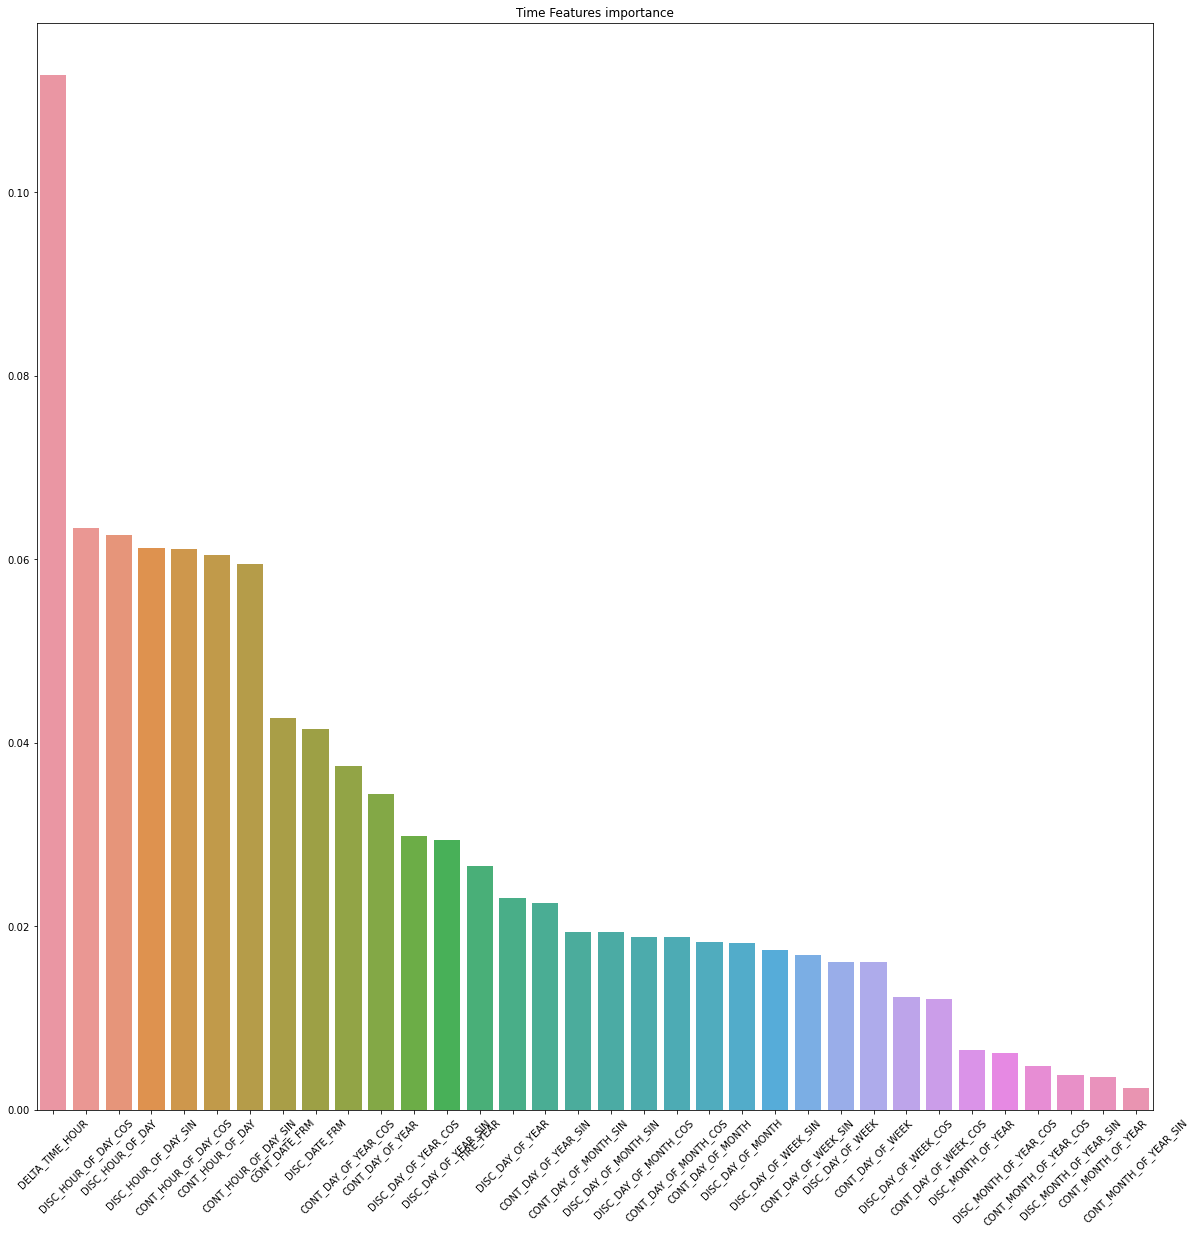

In [91]:
plt.figure(figsize=(20,20))
sns.barplot(x=columns, y=importances)
plt.xticks(rotation = 45) 
plt.title("Time Features importance")
plt.show()

Following this results we have concluded that the most important features are :
DELTA_TIME_HOUR, DISC_HOUR_OF_DAY_SIN, DISC_HOUR_OF_DAY_COS, CONT_HOUR_OF_DAY_COS, CONT_HOUR_OF_DAY_SIN and DISC_DATE_FRM.
We prefered to keep the cos and sin versions of the features, to get the cyclic attributes.
We can drop the rest of the time features to clean the data frame.

In [92]:
#final_time_features = ['DELTA_TIME_HOUR', 'DISC_HOUR_OF_DAY_SIN', 'DISC_HOUR_OF_DAY_COS', 'CONT_HOUR_OF_DAY_COS', 'CONT_HOUR_OF_DAY_SIN', 'DISC_DATE_FRM']
#final_time_features = ['DISC_DAY_OF_YEAR', 'DELTA_TIME_HOUR', 'DISC_DATE_FRM', 'CONT_DATE_FRM', 'DISC_HOUR_OF_DAY_SIN', 'DISC_HOUR_OF_DAY_COS']
final_time_features = ['DELTA_TIME_HOUR', 'DISC_DATE_FRM', 'CONT_DATE_FRM', 'DISC_DAY_OF_YEAR', 'DISC_HOUR_OF_DAY_SIN', 'DISC_HOUR_OF_DAY_COS', 'CONT_HOUR_OF_DAY_COS', 'CONT_HOUR_OF_DAY_SIN']

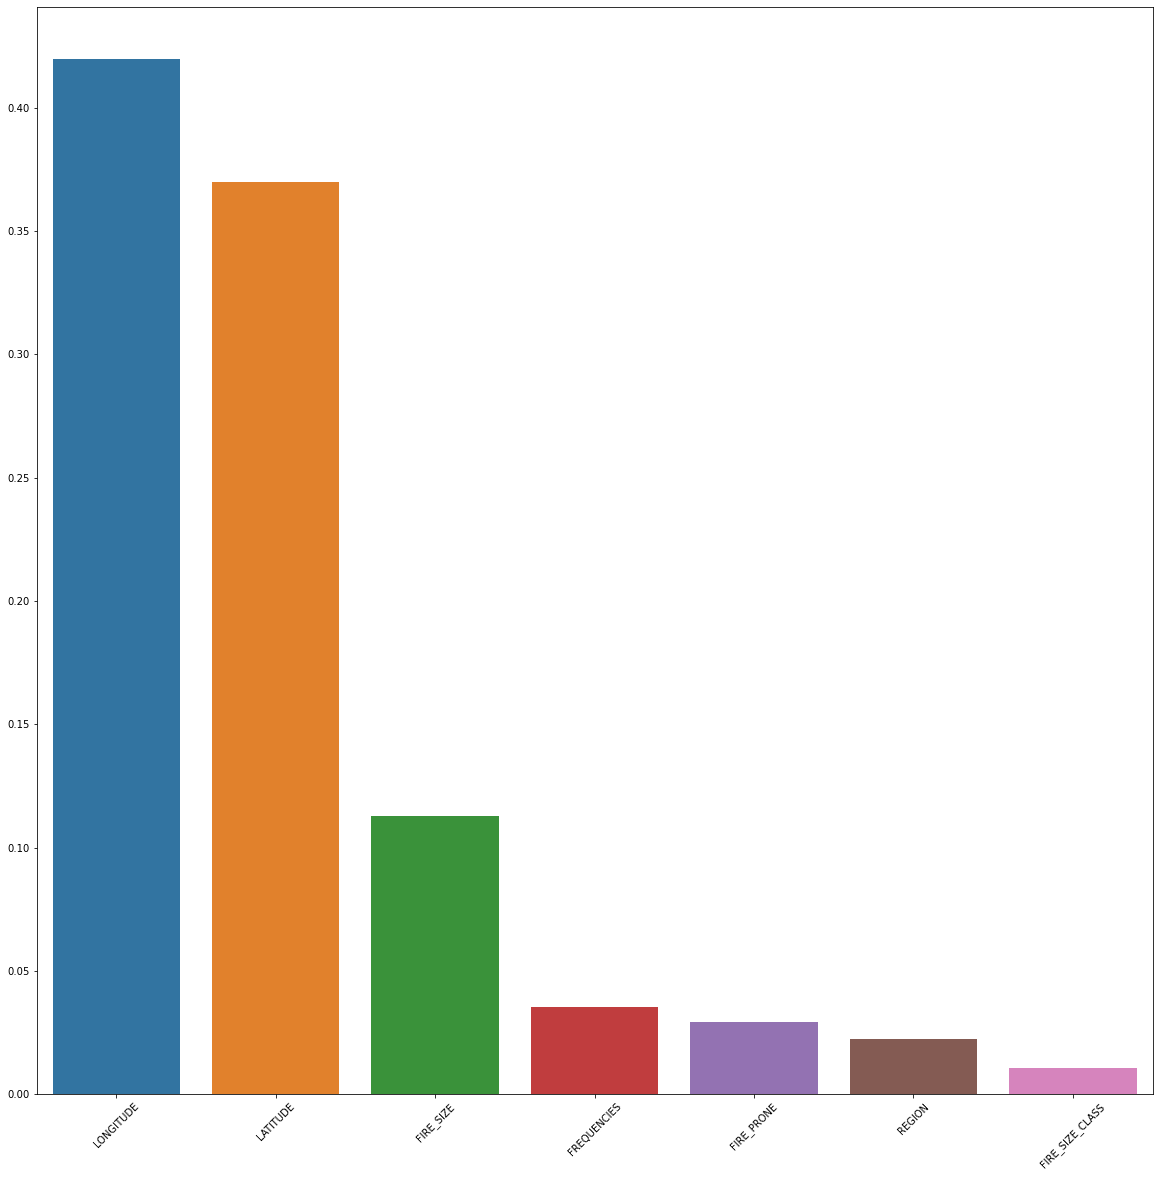

In [93]:
# Feature selection : other features
non_time_features = ['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
                'REGION', 'FREQUENCIES','FIRE_PRONE']
x = df_fires[non_time_features]
y = df_fires.iloc[x.index]['STAT_CAUSE_CODE']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
rf = RandomForestClassifier(random_state=6)
rf.fit(X_train, y_train)
feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
plt.figure(figsize=(20,20))
sns.barplot(x=columns, y=importances)
plt.xticks(rotation = 45) 
plt.show()

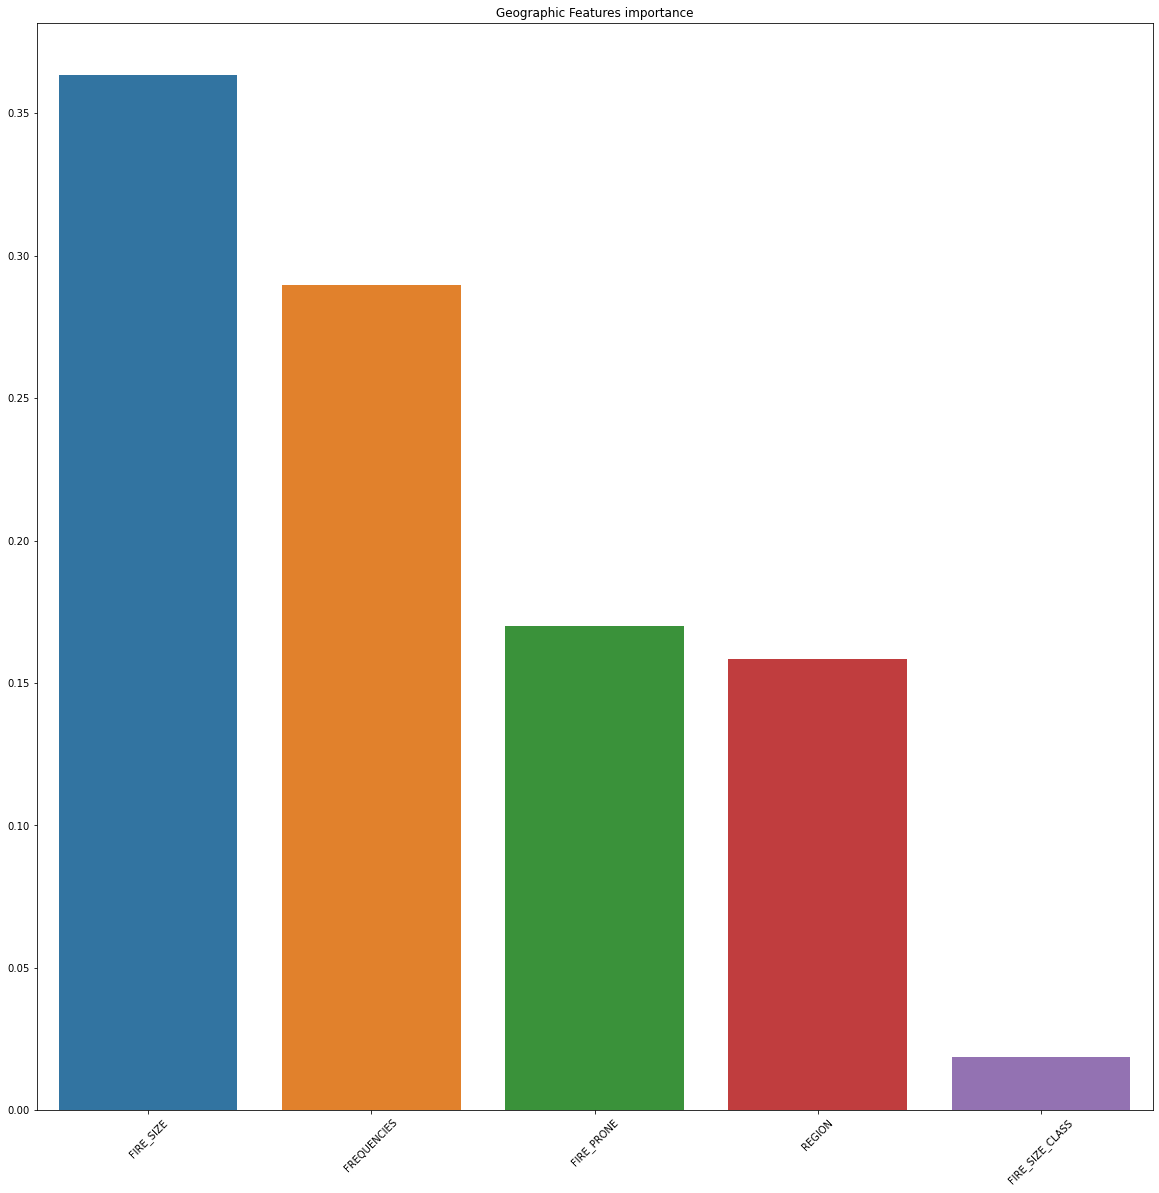

In [94]:
# Feature selection : other features
non_time_features = ['FIRE_SIZE', 'FIRE_SIZE_CLASS',
                'REGION', 'FREQUENCIES','FIRE_PRONE']
x = df_fires[non_time_features].dropna()
y = df_fires.iloc[x.index]['STAT_CAUSE_CODE']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
rf = RandomForestClassifier(random_state=6)
rf.fit(X_train, y_train)
feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
plt.figure(figsize=(20,20))
sns.barplot(x=columns, y=importances)
plt.xticks(rotation = 45) 
plt.title("Geographic Features importance")
plt.show()

In [95]:
# final_geography_features = ['FREQUENCIES', 'FIRE_SIZE', 'FIRE_PRONE', 'REGION']

In [96]:
final_geography_features = ['LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_PRONE']

## Model 

In [97]:
PREDICT_COLUMN_NAME = 'STAT_CAUSE_CODE'
df_model = df_fires[final_time_features+final_geography_features+ weather_feature +[PREDICT_COLUMN_NAME]]
x_train, x_test, y_train, y_test = train_test_split(df_model[final_time_features+final_geography_features],
                                                    df_model[PREDICT_COLUMN_NAME], test_size=0.3)

In [98]:
df_model

,DELTA_TIME_HOUR,DISC_DATE_FRM,CONT_DATE_FRM,DISC_DAY_OF_YEAR,DISC_HOUR_OF_DAY_SIN,DISC_HOUR_OF_DAY_COS,CONT_HOUR_OF_DAY_COS,CONT_HOUR_OF_DAY_SIN,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_PRONE,STORM,STAT_CAUSE_CODE
0,44.000000,1998.683094,1998.688569,218,-0.965926,0.258819,-7.071068e-01,-0.707107,44.913889,-116.605556,5.0,5,False,1.0
1,2.016667,1998.610712,1998.610712,191,-0.964787,-0.263031,2.588190e-01,-0.965926,42.690200,-113.034200,7.0,5,True,1.0
2,4.050000,1998.602498,1998.605236,188,-0.746057,0.665882,9.762960e-01,0.216440,42.869600,-115.841800,5.0,5,True,10.0
3,27.150000,1998.685832,1998.688569,219,-0.220697,-0.975342,-5.000000e-01,-0.866025,45.366667,-113.966667,4.0,5,False,1.0
4,2.000000,1998.904517,1998.904517,299,-0.991445,0.130526,6.087614e-01,-0.793353,44.567222,-117.028056,3.0,5,False,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297657,2.000000,2013.524641,2013.524641,160,-0.707107,-0.707107,-2.588190e-01,-0.965926,18.009444,-67.099444,26.2,4,False,7.0
297658,27.500000,2015.132615,2015.135352,18,-0.608761,-0.793353,-1.836970e-16,-1.000000,36.117800,-92.544400,1350.0,2,False,7.0
297659,2.500000,1994.912731,1994.912731,302,-0.793353,-0.608761,-1.836970e-16,-1.000000,41.575000,-78.836667,5.0,1,False,9.0
297660,79.600000,2010.344285,2010.352498,94,-0.533615,-0.845728,8.314696e-01,-0.555570,36.358333,-84.302778,1200.0,4,False,13.0


In [99]:
df_model.dtypes

DELTA_TIME_HOUR         float64
DISC_DATE_FRM           float64
CONT_DATE_FRM           float64
DISC_DAY_OF_YEAR          int64
DISC_HOUR_OF_DAY_SIN    float64
DISC_HOUR_OF_DAY_COS    float64
CONT_HOUR_OF_DAY_COS    float64
CONT_HOUR_OF_DAY_SIN    float64
LATITUDE                float64
LONGITUDE               float64
FIRE_SIZE               float64
FIRE_PRONE                int64
STORM                      bool
STAT_CAUSE_CODE         float64
dtype: object

In [100]:
# Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=60)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

In [101]:
from sklearn.metrics import f1_score

# F1 METRIC
f1_score(y_test, y_pred, average='weighted')

0.5661561795289584

In [102]:
df_model[PREDICT_COLUMN_NAME].unique()

array([ 1., 10.,  9.,  5., 11.,  3.,  2.,  8.,  6.,  4.,  7., 13., 12.])

In [103]:
sorted_descr = df[['STAT_CAUSE_DESCR', PREDICT_COLUMN_NAME]].drop_duplicates().sort_values(by=PREDICT_COLUMN_NAME)['STAT_CAUSE_DESCR']

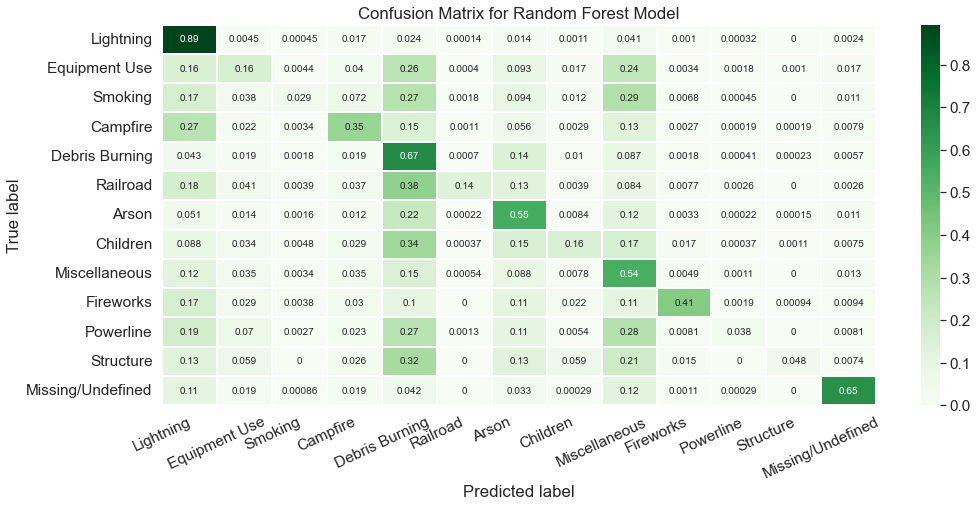

In [104]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(sorted_descr))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, sorted_descr, rotation=25)
plt.yticks(tick_marks2, sorted_descr, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()